In [ ]:
from google.colab import drive
import random
import numpy as np
import pandas as pd
import gzip
import nltk
from nltk import *
from nltk.corpus import webtext, stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
import textblob
from textblob import TextBlob
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("/content/gdrive/MyDrive/Dataset/reviews_CDs_and_Vinyl_5.json.gz")

In [ ]:
df.shape


(1097592, 9)

In [ ]:
df = df.sample(n=25000)

In [ ]:
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
395254,A1919WAE7DVH3T,B00000ILXT,"R. Rogers ""Gmbraska""","[0, 0]",This CD was a gift. It was received timely an...,5.0,Absolutely the Best CD,1294790400,"01 12, 2011"
91185,A2UVRU8KNCQVHC,B000001J33,Ricardo,"[0, 0]",As I espect the quality in the interpretation...,5.0,Marvelous,1362528000,"03 6, 2013"
936987,A34PRWLV61Y355,B001G2S436,Pseudonym,"[1, 1]",PIL was a headliner when they first played in ...,5.0,Classic Flipper,1338768000,"06 4, 2012"
800720,A36N2AMXOJDCSQ,B000AU1NYW,alainsane,"[0, 0]",This record comes up when you search for the U...,2.0,Beware: Argentinian Copy-Protected Version,1362787200,"03 9, 2013"
909411,A1Z3DUZZ8IUFVY,B0012GMWFW,"Paul Mcguinn ""paul from chi town""","[2, 2]",this album began the interesting carreer of on...,4.0,"b.o.c.,s amazing debut from 72!!",1252108800,"09 5, 2009"


In [ ]:
def preprocessing(text):
  text = re.sub("[^-9A-Za-z ]", "", text).lower()
  stop = stopwords.words("english")
  tokens = [word for word in (token for token in word_tokenize(text)) if word not in stop]
  #preprocessed_text = ' '.join([word for word in tokens])
  lmtzr = nltk.WordNetLemmatizer()
  preprocessed_text = ' '.join([lmtzr.lemmatize(word) for word in tokens])
  return preprocessed_text

In [ ]:
df['reviewText'] = df['reviewText'].astype(str)
df['reviewText'] = df['reviewText'].apply(preprocessing)

In [ ]:
text = list(df['reviewText'])

In [ ]:
print(text[0:30])


['cd gift received timely good like new condition pleased purchase seller one absolutely best amazon purchase made', 'espect quality interpretation question best fast receiving selller', 'pil headliner first played san francisco flipper supporting band - one moment support clearly original entertaining main act slow tempo grungy guitar ear-scouring feedback addiction beer contribute making album welcome memoriam pet rock band well represented studio recording public flipper limited youre going hear band genuine rare peel session contain band best recording pfl capture live chaos fun equal measure favorite like sex bomb shine wheel stand selection track - first half - offer accurate representation influenced generation band', 'record come search upc 9 unfortunately copy argentinian pressing dreaded copy controlled label inlay great album imo best since violator unforgivable buy cd cant rip mp', 'album began interesting carreer one favorite band blue oyster cult album proverbial kick-off

In [ ]:
words = [i for item in text for i in item.split()]


In [ ]:
print(words[:10])


['cd', 'gift', 'received', 'timely', 'good', 'like', 'new', 'condition', 'pleased', 'purchase']


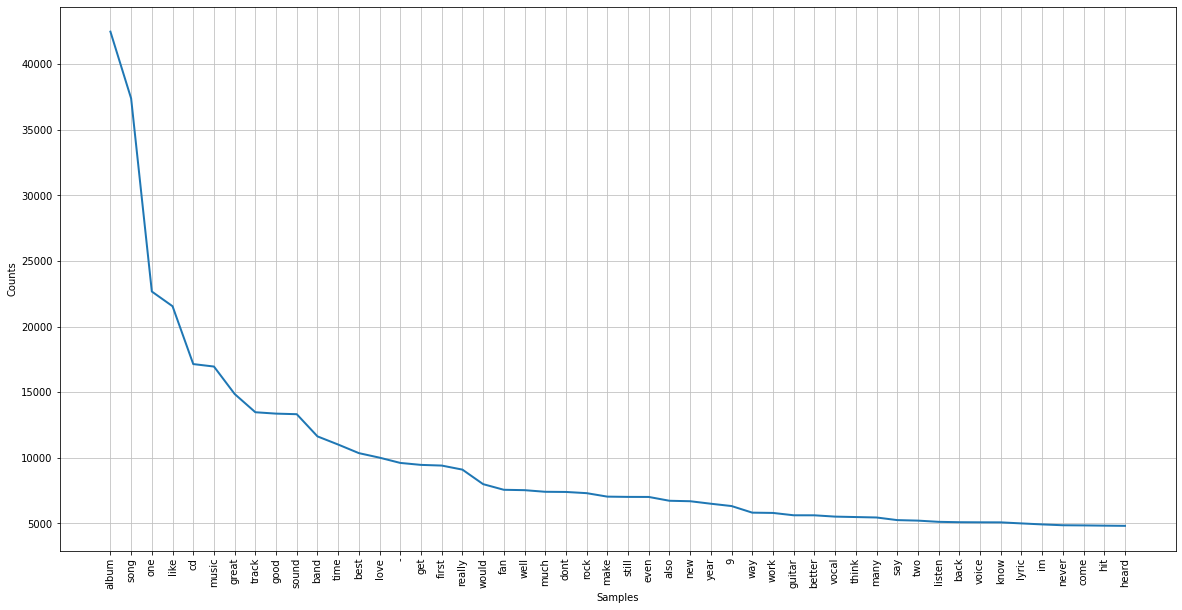

In [ ]:
plt.figure(figsize=(20, 10)) 
nlp_words = nltk.FreqDist(words)
nlp_words.plot(50)

In [ ]:
esBigrams = ngrams(words, 3)
esBigramFreq = collections.Counter(esBigrams)

In [ ]:
esBigramFreq.most_common(10)


[(('rock', 'n', 'roll'), 299),
 (('ive', 'ever', 'heard'), 239),
 (('--', '--', '--'), 202),
 (('one', 'best', 'album'), 193),
 (('best', 'song', 'album'), 184),
 (('dont', 'get', 'wrong'), 178),
 (('one', 'best', 'song'), 149),
 (('favorite', 'song', 'album'), 122),
 (('first', 'time', 'heard'), 120),
 (('song', 'sound', 'like'), 120)]

In [ ]:
df['tokenized_review'] = df.apply(lambda i:  nltk.word_tokenize(i['reviewText']), axis=1)
df['POS_Tags'] = df.apply(lambda i: nltk.pos_tag(i['tokenized_review']), axis=1)

In [ ]:
def adjectives(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag == 'JJ']
def verbs(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag.startswith('VB')]
def adverbs(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag.startswith('RB')]
def nouns(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag.startswith('NN')]

In [ ]:
df['Adjectives'] = df['reviewText'].apply(adjectives)
df['Verbs'] = df['reviewText'].apply(verbs)
df['Adverbs'] = df['reviewText'].apply(adverbs)
df['Nouns'] = df['reviewText'].apply(nouns)

In [ ]:
df.head(1)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,tokenized_review,POS_Tags,Adjectives,Verbs,Adverbs,Nouns
395254,A1919WAE7DVH3T,B00000ILXT,"R. Rogers ""Gmbraska""","[0, 0]",cd gift received timely good like new conditio...,5.0,Absolutely the Best CD,1294790400,"01 12, 2011","[cd, gift, received, timely, good, like, new, ...","[(cd, NN), (gift, NN), (received, VBD), (timel...","[good, new, pleased, amazon]","[received, made]","[timely, absolutely, best]","[cd, gift, condition, purchase, seller, purchase]"


In [ ]:
def POS_freq(words):
  POS = list(words)
  POS = [y for x in POS for y in x]
  plt.figure(figsize=(20, 10)) 
  nlp_words = nltk.FreqDist(POS)
  nlp_words.plot(50)

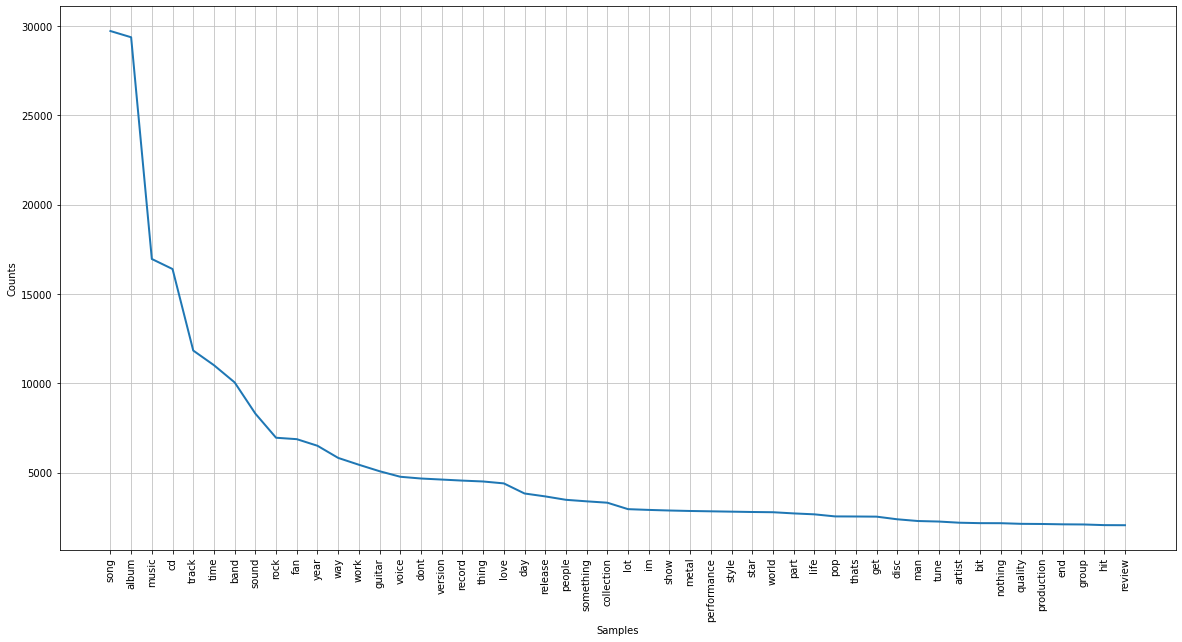

In [ ]:
POS_freq(df['Nouns'])


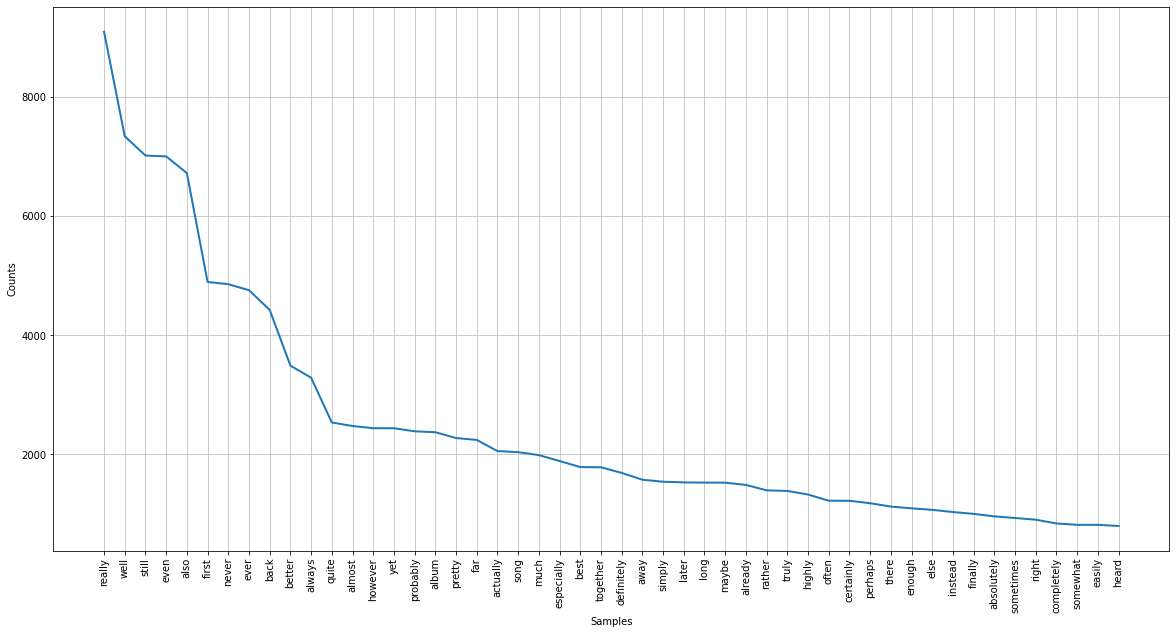

In [ ]:
POS_freq(df['Adverbs'])


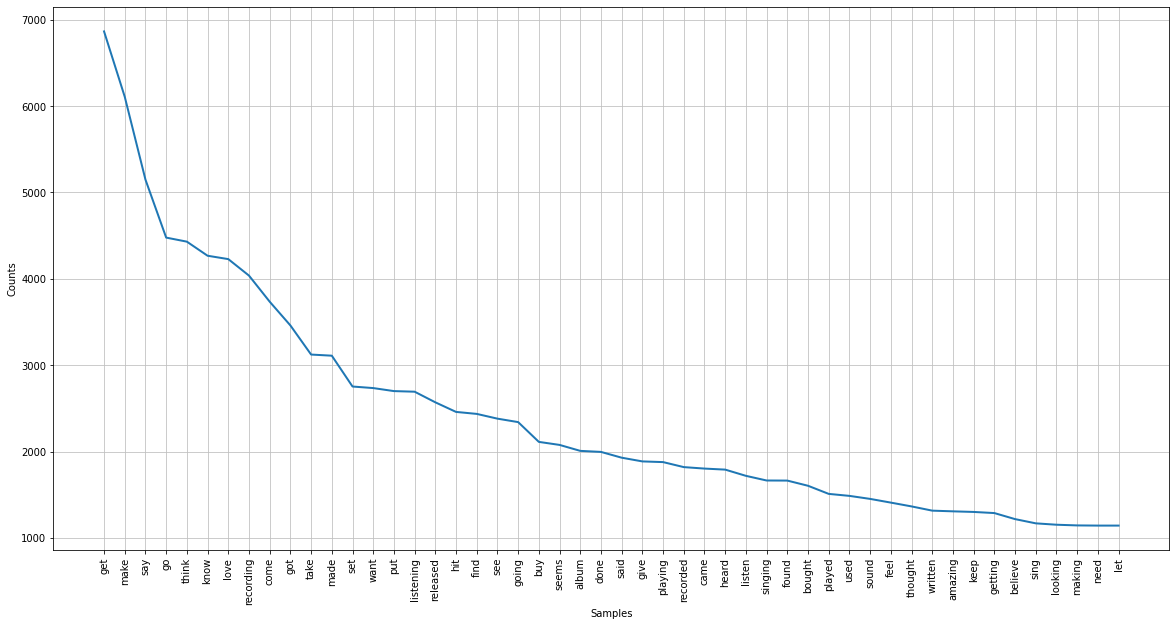

In [ ]:
POS_freq(df['Verbs'])


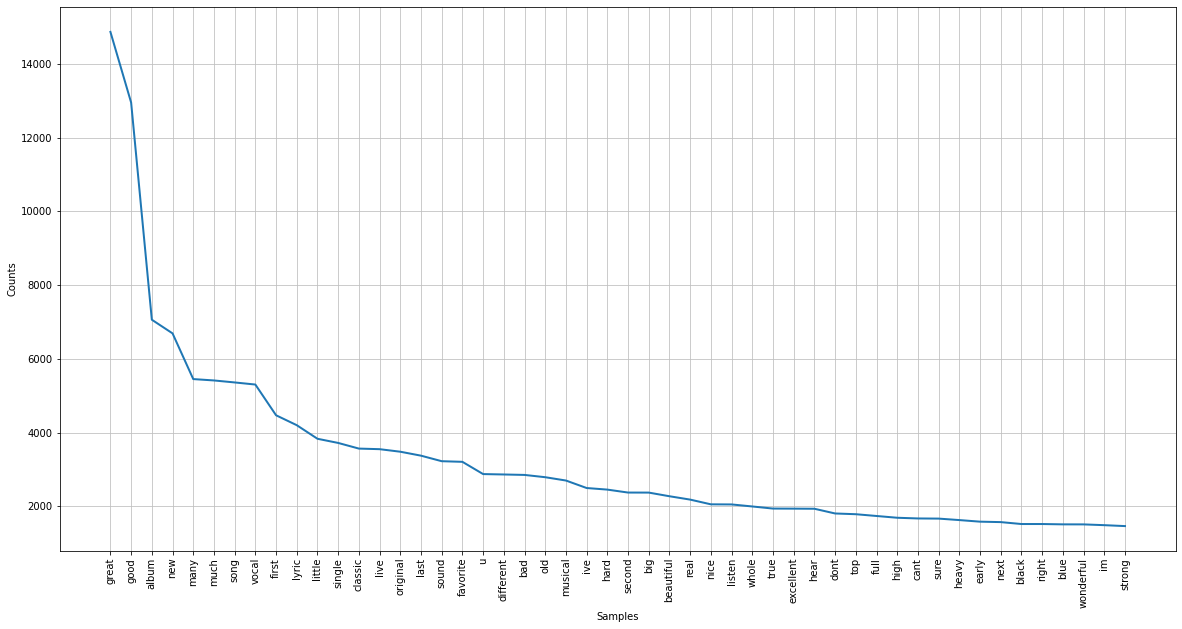

In [ ]:
POS_freq(df['Adjectives'])


In [ ]:
NER = spacy.load("en_core_web_sm")


In [ ]:
named_entities = []
for sentence in text:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = NER(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [ ]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:100]

In [ ]:
def key_words(n):

  kwargs = {
            'ngram_range': (1, 2), 
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word', 
            'min_df': 2,
    }
  vectorizer = TfidfVectorizer(**kwargs)
  tfidf_matrix = vectorizer.fit_transform(df['reviewText'])
  important_words_indices = np.argsort(np.asarray(tfidf_matrix.sum(axis=0))[0])[::-1]
  tfidf_feature_names = np.array(vectorizer.get_feature_names())
  print(tfidf_feature_names[important_words_indices[:n]])
  importance = np.asarray(tfidf_matrix.sum(axis=0))[0]
  plt.figure(figsize=(20, 10))
  plt.plot(tfidf_feature_names[important_words_indices[:n]], importance[important_words_indices[:n]])
  plt.xticks(rotation = 45)
  plt.xlabel("Key Words")
  plt.ylabel("Importance")
  plt.show()

In [ ]:
key_words(30)
